# SRD+LF Corner Plots

Here we will generate corner plots for the SRD+LF forecasts. We will compare the SRD+LF forecasts with the SRD forecasts for both the year 1 (Y1) and year 10 (Y10) LSST epochs.

In [1]:
from getdist import plots
import numpy as np
import matplotlib.pyplot as plt
from processing import gaussians_processing as gp
from processing import fisher_processing as fp
from processing import helpers as h

In [2]:
corner_path = "jmas_data/corner_plot_data/"
parameters = np.load(f"{corner_path}corner_plot_parameters.npy",
                     allow_pickle=True).item()
fisher_matrices = fp.fisher_matrices
inverse_fisher_matrices = fp.inverse_fisher_matrices
inverse_fisher_matrices_clipped = fp.inverse_fisher_matrices_clipped
gaussians_clipped = gp.gaussians_clipped


In [3]:
corner_colors = h.corner_colors
plots_path = f"plots_output/corner_plots/"
cosmoiaplot = h.cosmoiaplot


## SRD+LF vs SRD

CPU times: user 6min 30s, sys: 26.7 s, total: 6min 57s
Wall time: 2min 17s


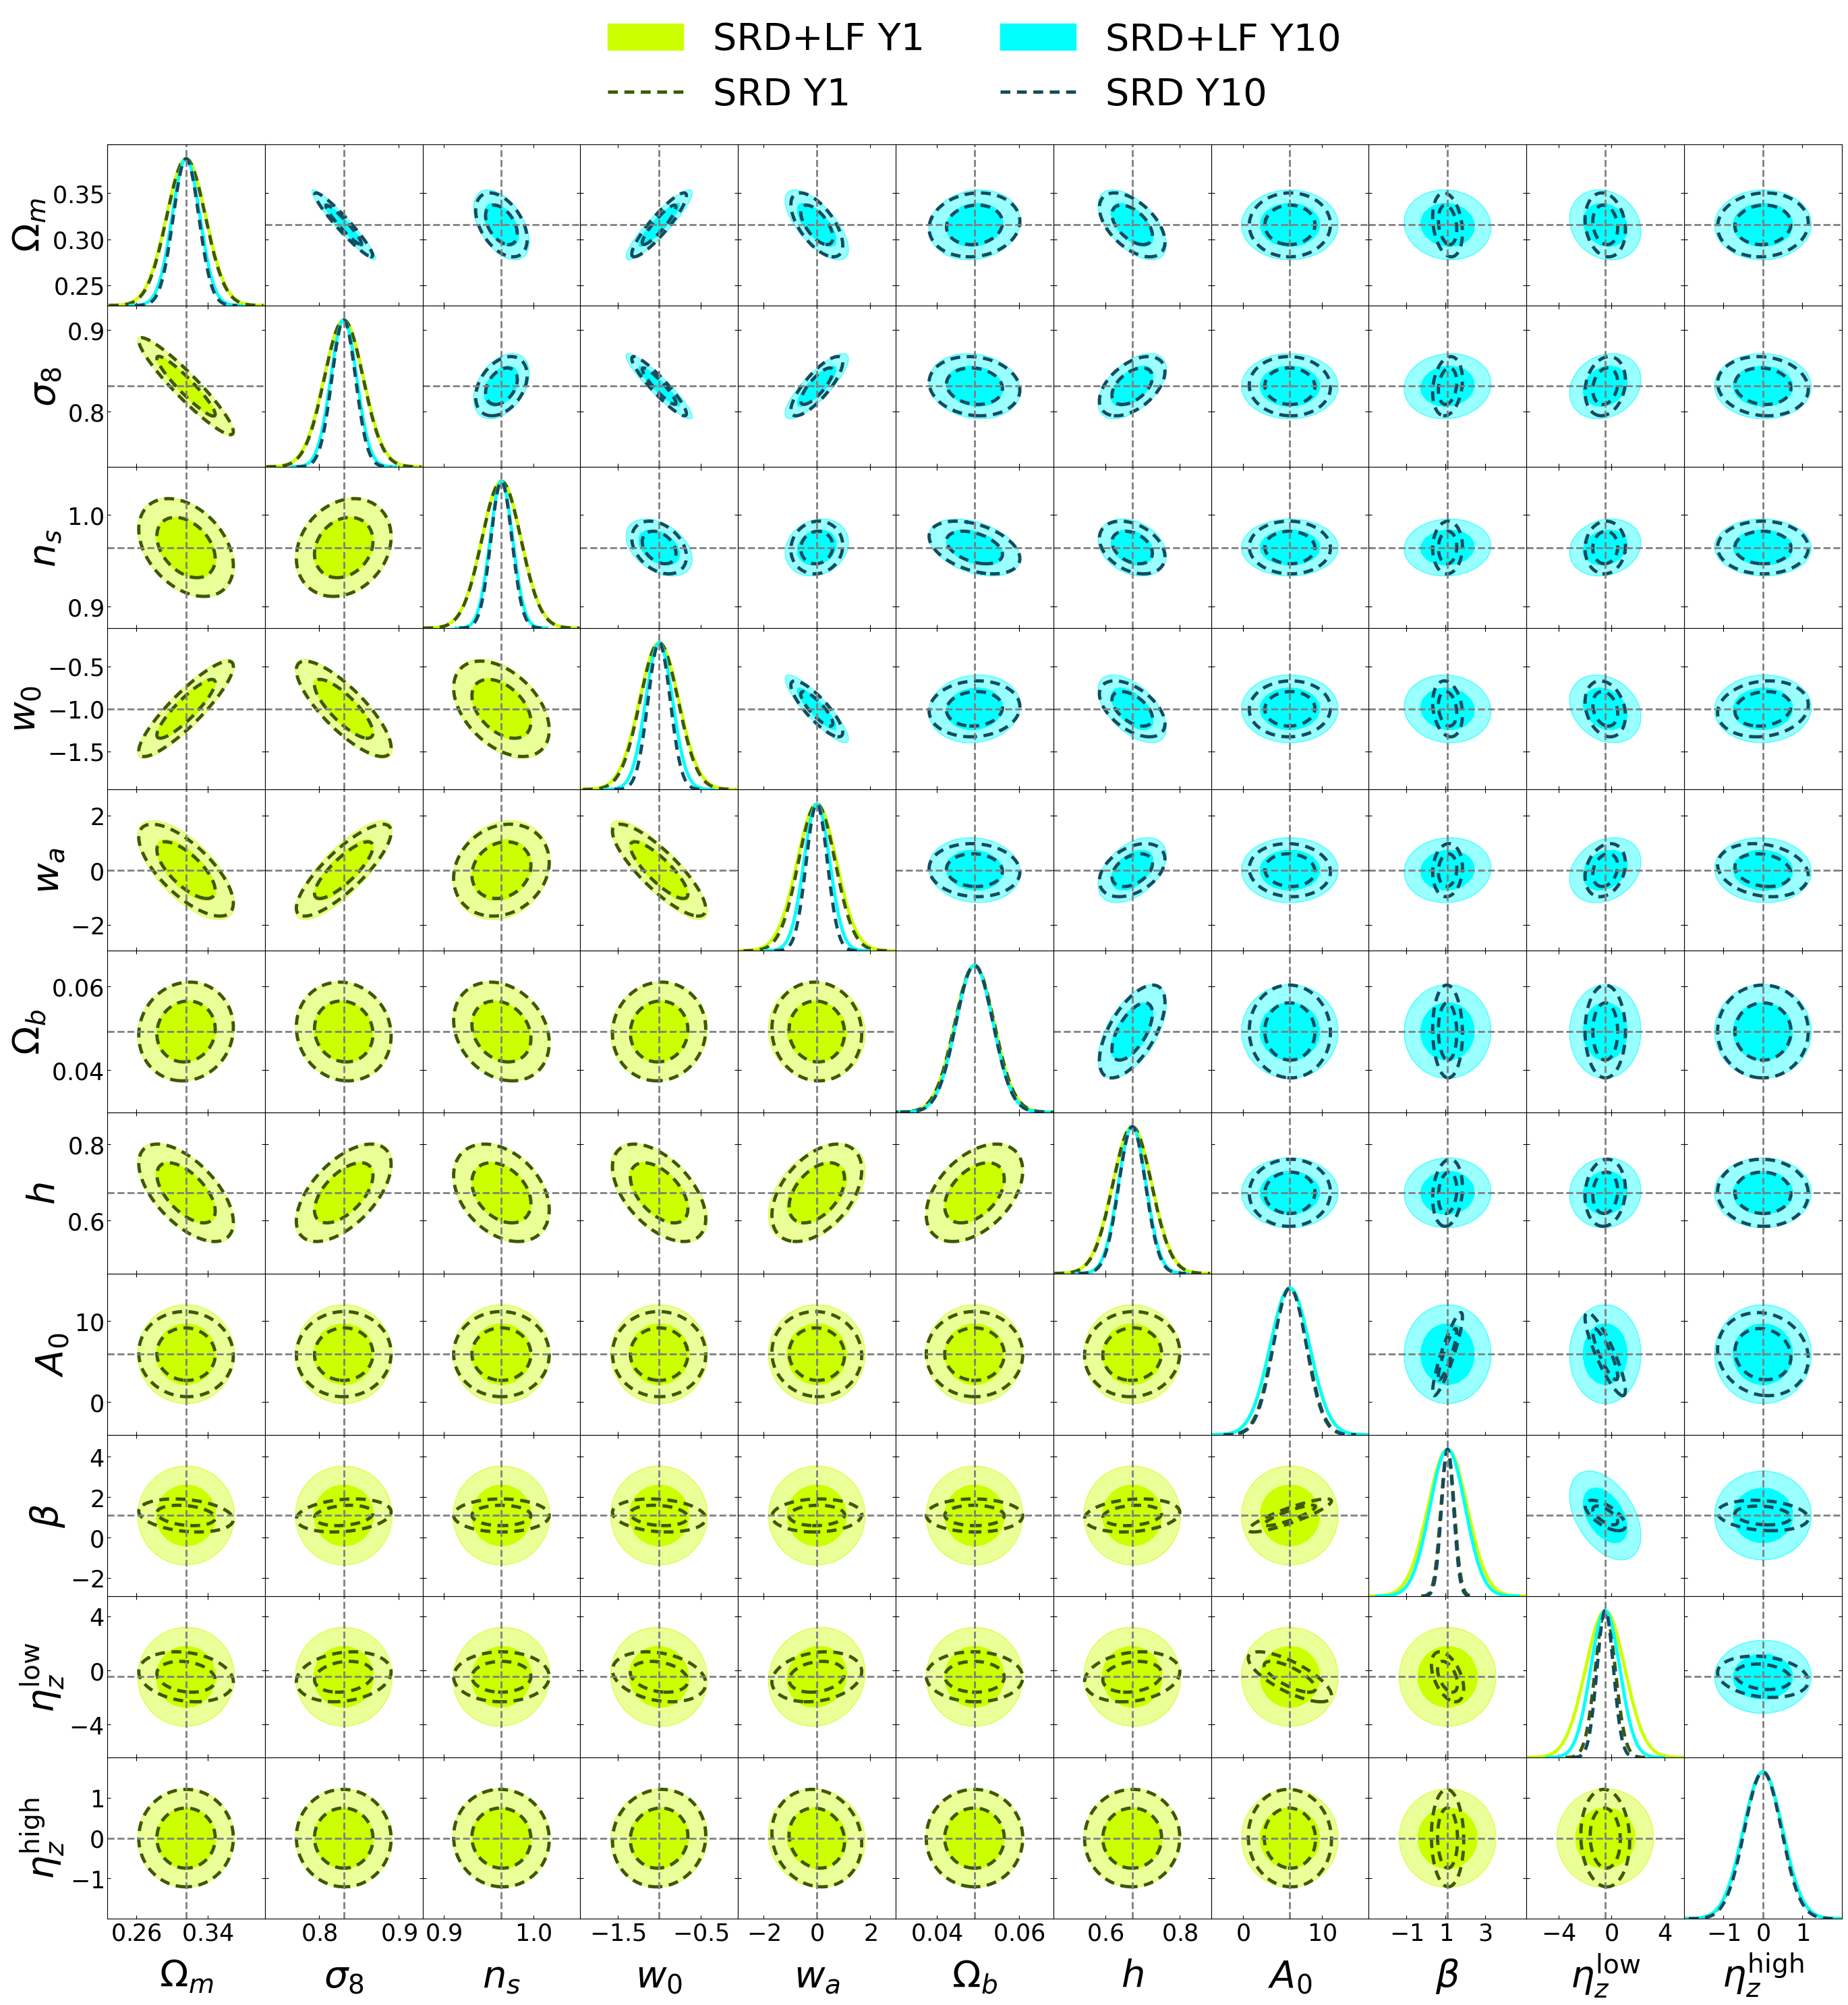

In [4]:
%%time

legend_labels = ["SRD+LF Y1", "SRD Y1",
                 "SRD+LF Y10", "SRD Y10"]

lower_kwargs = {'contour_colors': [corner_colors["srd+lf"]["1"],
                                   corner_colors["srd"]["1"],],
                "filled":[True, False, ],
                "contour_ls":["-", "--",],
                "contour_lws":[3.5, 3.5],}
upper_kwargs = {'contour_colors': [corner_colors["srd+lf"]["10"],
                                   corner_colors["srd"]["10"]],
                "filled":[True, False],
                "contour_ls":["-", "--"],
                "contour_lws":[3.5, 3.5],}

lower_covmats = [
    gaussians_clipped["srd+lf"]["cosmoia"]["1"],
    gaussians_clipped["srd"]["cosmoia"]["1"],
]

upper_covmats = [
    gaussians_clipped["srd+lf"]["cosmoia"]["10"],
    gaussians_clipped["srd"]["cosmoia"]["10"],
]

cosmoiaplot.triangle_plot(lower_covmats,
                legend_labels=legend_labels,
                upper_roots=upper_covmats,
                upper_kwargs=upper_kwargs,
                legend_ncol=2,
                markers=parameters["values"]["srd"]["cosmoia"]["1"],
                **lower_kwargs)
plt.gcf().set_size_inches(30,30) 

# Save the figure with the title
plt.savefig(f"{plots_path}corner_srdlf_vs_srd_cosmoia.pdf", bbox_inches="tight")
plt.savefig(f"{plots_path}corner_srdlf_vs_srd_cosmoia.png", bbox_inches="tight", dpi=300)


## SRD+LF vs SRD: Simple Statistics

In [5]:
years = ["1", "10"]
stats = {}

for year in years:
    # Compute statistics for each type and year
    srd_means, srd_stds = h.get_stats(inverse_fisher_matrices_clipped["srd"]["cosmoia"][year], 
                                          parameters["values"]["srd"]["cosmoia"][year])
    srdlf_means, srdlf_stds = h.get_stats(inverse_fisher_matrices_clipped["srd+lf"]["cosmoia"][year], 
                                          parameters["values"]["srd+lf"]["cosmoia"][year])

    # Compute the fractional differences
    frac_diff_srdlfsrd = h.get_fractional_difference(srdlf_stds, srd_stds)

    # Store results in the dictionary
    stats[year] = {
        "srd_means": srd_means,
        "srd_stds": srd_stds,
        "srdlf_means": srdlf_means,
        "srdlf_stds": srdlf_stds,
        "frac_diff_srdlfsrd": frac_diff_srdlfsrd,
    }


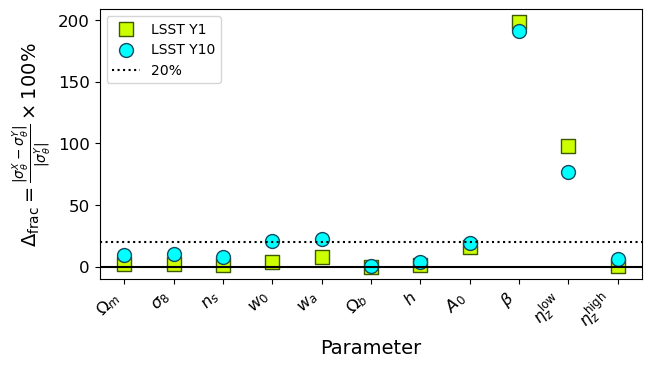

In [6]:
# Set up the figure
plt.figure(figsize=(7, 3.5))

# Define specific colors for each year
colors = {'1': corner_colors["srd+lf"]["1"], '10': corner_colors["srd+lf"]["10"]}
markers = {'1': "s", '10': "o"}
edge = {'1': corner_colors["srd"]["1"], '10': corner_colors["srd"]["10"]}

# Create a list of indices for the x-tick positions
xtick_positions = list(range(len(parameters["labels"]["srd"]["cosmoia"]['1'])))

# Iterate over the years and plot each on the same graph
for year in years:
    # Access the fractional difference for the current year
    symm_diff = stats[year]["frac_diff_srdlfsrd"]
    plt.scatter(xtick_positions, symm_diff, 
                color=colors[year], 
                label=f"LSST Y{year}",
                s=100,
                marker=markers[year],
                edgecolors=edge[year])

plt.xlabel("Parameter", fontsize=14)
plt.ylabel(r'$\Delta_{\text{frac}} = \frac{|\sigma_\theta^X - \sigma_\theta^Y|}{|\sigma_\theta^Y|} \times 100\%$',
           fontsize=14)

# Lines for reference
plt.axhline(0, color="k", ls="-")
plt.axhline(20, color="k", ls=":", label="20%")

# Set x-tick labels in math mode
xtick_labels = parameters['labels']['srd']['cosmoia']['1']
plt.xticks(xtick_positions, [r'$%s$' % label for label in xtick_labels], rotation=45, ha='right')
plt.tick_params(axis='both', which='major', labelsize=12)

# Add legend
plt.legend(frameon=True, loc=2)

# Save the figure
plt.savefig(f"{plots_path}srdlf_vs_srd_stats.pdf", bbox_inches="tight")
plt.savefig(f"{plots_path}srdlf_vs_srd_stats.png", bbox_inches="tight", dpi=300)

plt.show()
